#Problem statement
We want to teach, with a simple neural network, multiplicative tables from 1 to 10 to our system. Its training data will be built on a list of tuple of three numbers.
This is a basic Hello world example and its objective is to start to use Tensorflow 2.0 with Keras API. 
Thus, let's start to import required libraries specifying to codelab to use version 2 of Tensorflow
 

In [0]:
%tensorflow_version 2.x
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We can read data directly from github

In [0]:
#local_url='./sample_data/mult_2.csv'
git_hub_url="https://raw.githubusercontent.com/rosidotidev/HelloWorldDL/master/mult_2.csv"
df = pd.read_csv(git_hub_url, sep=';')

In [5]:
df

,A,B,RESULT
0,1,6,6
1,1,8,8
2,2,4,8
3,2,3,6
4,2,2,4
5,2,1,2
6,3,5,15
7,3,9,27
8,3,4,12
9,3,9,27


Let's split features from results and split again train data from test data

In [0]:
X = df.drop('RESULT',axis=1)
y = df['RESULT']

In [0]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=69)
X_test

,A,B
25,7,7
21,5,5
17,5,3
27,7,3
4,2,2
29,8,1
34,10,3
13,4,9


Tensorflow likes to work with normalized data, so let's use MinMaxScaler to do that

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
X_train.shape

(29, 2)

In [11]:
X_test.shape

(8, 2)

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
model = Sequential()

model.add(Dense(2,activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dense(500,activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [17]:
model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=64,epochs=5000,
          callbacks=[early_stop])

Train on 29 samples, validate on 8 samples
Epoch 1/5000
29/29 [==============================] - 0s 13ms/sample - loss: 1133.8417 - val_loss: 744.3070
Epoch 2/5000
29/29 [==============================] - 0s 430us/sample - loss: 1133.0791 - val_loss: 743.3632
Epoch 3/5000
29/29 [==============================] - 0s 424us/sample - loss: 1132.2549 - val_loss: 742.3132
Epoch 4/5000
29/29 [==============================] - 0s 433us/sample - loss: 1131.3297 - val_loss: 741.1408
Epoch 5/5000
29/29 [==============================] - 0s 443us/sample - loss: 1130.2902 - val_loss: 739.8783
Epoch 6/5000
29/29 [==============================] - 0s 410us/sample - loss: 1129.1597 - val_loss: 738.5177
Epoch 7/5000
29/29 [==============================] - 0s 405us/sample - loss: 1127.9240 - val_loss: 737.0469
Epoch 8/5000
29/29 [==============================] - 0s 420us/sample - loss: 1126.5764 - val_loss: 735.4567
Epoch 9/5000
29/29 [==============================] - 0s 412us/sample - loss: 1125.106

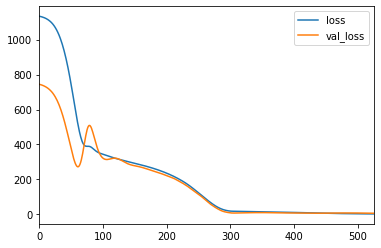

In [18]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [0]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

In [0]:
predictions = model.predict(X_test)

In [21]:
current_mse=mean_absolute_error(y_test,predictions)
current_mse

1.8050009608268738

In [0]:
def compare_with_best_model(curr_model,X_test,y_test):
    best_model=None
    try:
        best_model=tf.keras.models.load_model('./sample_data/best_model.h5') 
        best_pred=best_model.predict(X_test)
        best_mse=mean_absolute_error(y_test,best_pred)
        
        curr_pred= curr_model.predict(X_test)
        curr_mse= mean_absolute_error(y_test,curr_pred)
        if curr_mse<best_mse:
            curr_model.save('./sample_data/best_model.h5')
            best_model=curr_model
            print(f"New best model with mse {curr_mse}")
        else:
            print(f"No new best model, still best mse {best_mse}")
    except:
        print("No best model found")
        best_model=curr_model
        
    return best_model



In [23]:
model = compare_with_best_model(model,X_test,y_test)
 
def predict_function(a,b,best_model,scaler):
    tmp=[[a,b]]
    tmp=scaler.transform(tmp)
    pred=best_model.predict(tmp)
    #tmpDF=pd.DataFrame({'A': [a],'B': [b]})
    #tmpDF=scaler.transform(tmpDF)
    #pred=best_model.predict(tmpDF)
    return pred[0][0]



No new best model, still best mse 0.3222756087779999


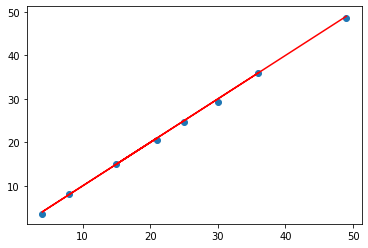

In [24]:
predictions = model.predict(X_test)
# Our predictions
plt.scatter(y_test,predictions)
# Perfect predictions
plt.plot(y_test,y_test,'r')

## Let's test our best module with 5 multiplications it had never seen

In [30]:
print("8 * 2 = {}".format(round(predict_function(8,2,model,scaler))))
print("7 * 2 = {}".format(round(predict_function(7,2,model,scaler))))
print("5 * 6 = {}".format(round(predict_function(5,6,model,scaler))))
print("8 * 8 = {}".format(round(predict_function(8,8,model,scaler))))
print("8 * 5 = {}".format(round(predict_function(8,5,model,scaler))))

8 * 2 = 15.0
7 * 2 = 13.0
5 * 6 = 30.0
8 * 8 = 62.0
8 * 5 = 40.0


In [31]:
model.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_399 (Dense)            multiple                  6         
_________________________________________________________________
dense_400 (Dense)            multiple                  90        
_________________________________________________________________
dense_401 (Dense)            multiple                  15500     
_________________________________________________________________
dense_402 (Dense)            multiple                  15030     
_________________________________________________________________
dense_403 (Dense)            multiple                  31        
Total params: 30,657
Trainable params: 30,657
Non-trainable params: 0
_________________________________________________________________


# New Section